# **Finding Lane Lines on the Road** 
Cem Ozen
12/06/2016
***

Recenttly I started a new adventure by enrolling into Udacity SDCND program. This program is a great opportunity for people like me who wants to develope new skills. I just completed my first week and I have to admit that I am very impressed with the program in general. 

This post will include the step by step process that I implemented for the first project of the course which is "Finding Lane Lines". The code is developed in Python using OpenCV. It can process both image and video files. 

## Helper Functions
***

In [1]:
# Import packages necessary for the computations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import sys
import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [2]:
def read_image(filepath):
    """
    Accepts images of type jpeg and png
    :param filepath: path to desired image
    :return: image in 0, 255 byte scale
    """
    extentsion = filepath.split(".")[-1]

    if str(extentsion).upper() in ("JPG", "JPEG"):
        return mpimg.imread(filepath)
    elif str(extentsion).upper() == "PNG":
        return (mpimg.imread(filepath)*255).astype('uint8')
    else:
        sys.exit("Unknown file type - try jpg and png files")

In [3]:
def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')
    :param img: image to be converted to grayscale
    :return: image in grayscale
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
def hsvscale(img):
    """
    Applies the HSV transform
    :param img: image to be converted to HSV scale
    :return: transformed image
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [5]:
def hslscale(img):
    """
    Applies the HSL transform
    :param img: image to be converted to HSL scale
    :return: transformed image
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSL)

In [6]:
def hsv_mask(img):
    """
    Selects only green and white regions in the image after applying HSV transform
    :param img: image for masking
    :return: maked image
    """
    
    # Define the lower and upper bounds for the white color
    white_lwr = np.array([0, 0, 200])
    white_upr = np.array([180, 255, 255])
    
    # Define the lower and upper bounds for the yellow color
    yellow_lwr = np.array([20, 100, 100])
    yellow_upr = np.array([30, 255, 255])
    
    # Convert the scale from BGR to HSV
    hsv_img = hsvscale(img)
    
    # Get the white color mask
    white_mask = cv2.inRange(hsv_img, white_lwr, white_upr)


    # Get the yellow color mask
    yellow_mask = cv2.inRange(hsv_img, yellow_lwr, yellow_upr)
    
    # Combine two masks
    mask_combined = white_mask | yellow_mask

    # Use bitwise_and to mask the original image
    return cv2.bitwise_and(img, img, mask=mask_combined)

In [7]:
def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian kernel to reduce the noise in the image
    :param img: image for smoothing
    :param kernel_size: kernel size to be applied for the gaussian 
    :return: smoothed image
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [8]:
def canny(img, low_threshold, high_threshold):
    """
    Applies the Canny transform
    :param img: image 
    :param low_threshold: lower bound for signal rejection
    :param high_threshold: upper bound for detecting strong edges 
    :return: transformed image
    """
    return cv2.Canny(img, low_threshold, high_threshold)

In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    :param img: image 
    :param vertices: vertices for the polygon
    :return: masked image
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws line segments onto image
    This function modifies the given image and draws lines on it. 
    The lines are based on the coordinates of 2 points
    :param img: image 
    :param lines: end point pairs for all line segments
    :param color: desired line color
    :param thickness: desired line thickness
    :return: image with lines
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [11]:
def draw_lines2(img, lines, min_y, weight, color=[[255, 0, 0], [0, 255, 0]], thickness = 15):
    """
    Draws left and right lane lines
    This function modifies the given image and draws lines on it. 
    The lines are based on the coordinates of 2 points
    :param img: image 
    :param lines: end point pairs for all line segments
    :param min_y: minimum y value for extending lines
    :param weight: weight factor for frame to frame smoothing
    :param color: desired line color
    :param thickness: desired line thickness
    :return: image with lines
    """
    
    # Global variable to store the information of previous frame 
    global prev_lines, is_video_file
    
    # Go through each line segment and classify them as right and left lines based on their slode
    # Store slope, intercept and length for each line segment
    left_line = []
    right_line = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if (0.4 < slope < 1.0) or (-1.0 < slope < -0.4):
                intercept = y1 - slope * x1
                length = math.sqrt((y2 - y1)**2.0 + (x2 - x1)**2.0)
                if slope > 0 :
                    left_line.append((slope, intercept, length))
                elif slope < 0:
                    right_line.append((slope, intercept, length))
            else:
                pass
    
    # Find the average slope and intercept for each line
    # Use line lengths as the weights so that longer segments dominate the averages
    left_line = np.array(left_line)
    left_line_slope = np.average(left_line[:, 0], weights=left_line[:, 2])
    left_line_intercept = np.average(left_line[:, 1], weights=left_line[:, 2])

    right_line = np.array(right_line)
    right_line_slope = np.average(right_line[:, 0], weights=right_line[:, 2])
    right_line_intercept = np.average(right_line[:, 1], weights=right_line[:, 2])
    
    # When processing video files, there can be frame to frame jitter in the drawn lines 
    # To eliminate, we can use the line information from the previous frame and calculate
    # a weighted average line 
    # w= 0.5 will place equal importance to both results while w > 0.5 will increase the contribution coming from the previous frame
    if not prev_lines:
        pass
    else:
        left_line_slope = weight * prev_lines[0][0] + (1.0 - weight) * left_line_slope
        left_line_intercept = weight * prev_lines[0][1] + (1.0 - weight) * left_line_intercept
        right_line_slope = weight * prev_lines[1][0] + (1.0 - weight) * right_line_slope
        right_line_intercept = weight * prev_lines[1][1] + (1.0 - weight) * right_line_intercept
    
    if is_video_file:
        prev_lines= tuple(((left_line_slope, left_line_intercept), (right_line_slope, right_line_intercept)))
    
    
    # Now using the line slope and intercept we will draw line that extend between the top 
    # section of the mask (min_y) and bottom of the image (max y)
    img_shape = img.shape

    left_y1 = img_shape[0]
    left_x1 = int((left_y1 - left_line_intercept) / left_line_slope)

    left_y2 = min_y
    left_x2 = int((left_y2 - left_line_intercept) / left_line_slope)

    right_y1 = img_shape[0]
    right_x1 = int((right_y1 - right_line_intercept) / right_line_slope)

    right_y2 = min_y
    right_x2 = int((right_y2 - right_line_intercept) / right_line_slope)
    
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color[0], thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color[1], thickness)

In [12]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Calculates hough line segments and draws them one the image provided
    :param img: should be the output of a Canny transform.
    :param rho: radial distance from the center
    :param theta: rotation angle 
    :param threshold: threshold for intersection counts
    :param min_line_len: minimum line length limit
    :param max_line_gap: maximum allowed line gap in pixels
    :return: Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [13]:
def hough_lines_smooth(img, rho, theta, threshold, min_line_len, max_line_gap, min_y, weight):
    """
    Calculates hough line segments and draws extrapolated lines one the image provided
    :param img: should be the output of a Canny transform.
    :param rho: radial distance from the center
    :param theta: rotation angle 
    :param threshold: threshold for intersection counts
    :param min_line_len: minimum line length limit
    :param max_line_gap: maximum allowed line gap in pixels
    :return: Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines2(line_img, lines, min_y, weight)
    return line_img

In [14]:
def weighted_img(img, initial_img, α=1.0, β=0.5, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Main Pipeline
***
Note: For the challenge program deactivate the current **min_y** and **vertices** and activate the ones that are commented out

In [15]:
def process_image(image):
    """
    Pipeline for the whole process
    """
    # Read in image, get some basic info and display the image
    img_type = type(image)
    img_shape = image.shape
    # print('\nThis image is:', img_type, 'with dimesions:', img_shape)


    # Apply color selection
    hsv_masked_image = hsv_mask(image)
    # plt.imshow(hsv_masked_image)
    # plt.show()

    # Convert it into grayscale and display again
    gray = grayscale(hsv_masked_image)
    # plt.imshow(gray, cmap='gray')
    # plt.show()

    # Smooth the image to get more accurate results
    # Define the kernel size for gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny edge detection
    # Define low and high theresholds
    low_threshold = 100
    high_threshold = 200
    edges = canny(blur_gray, low_threshold, high_threshold)
    # plt.imshow(edges, cmap="gray")
    # plt.show()

    # Apply a mask for the region of interest
    # Define the vertices for the region of interest
    min_y = 340
    # min_y = 475
    vertices = np.array([[(0,img_shape[0]),
                          (450, min_y),
                          (550, min_y),
                          (img_shape[1],img_shape[0])]], dtype=np.int32)
    # vertices = np.array([[(0,650),
    #                       (550, min_y),
    #                       (750, min_y),
    #                       (img_shape[1],650)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # plt.imshow(masked_edges, cmap="gray")
    # plt.show()

    # Apply the Hough transformation for getting the lines
    rho = 1
    theta = np.pi / 180
    threshold_hough = 20  # 15
    min_line_length = 7  # 10
    max_line_gap = 5  # 5
    line_image = hough_lines(masked_edges, rho, theta, threshold_hough, min_line_length, max_line_gap)
    filter_weight = 0.75
    line_image_smooth = hough_lines_smooth(masked_edges, rho, theta, threshold_hough, min_line_length, max_line_gap,
                                           min_y, filter_weight)
    # plt.imshow(line_image, cmap="gray")
    # plt.show()

    # Draw the lines on the initial image
    line_edges = weighted_img(line_image, image)
    line_edges_smooth = weighted_img(line_image_smooth, image)
    
    if not is_video_file:
        fig = plt.figure()
        a=fig.add_subplot(1,2,1)
        a.set_title("Lane lines")
        plt.imshow(line_edges)
        a=fig.add_subplot(1,2,2)
        a.set_title("Smoothed lane lines")
        plt.imshow(line_edges_smooth)
        plt.show()

    return line_edges_smooth

## Process Images
***
Function to run pipeline for the images in the **test_images** folder. 

In [16]:
def run_images():
    """
    Read all the images in the folder, process, display and write them. 
    """
    for img_name in os.listdir("test_images/"):
        folder_name = "test_images"
        path = folder_name + "/" + img_name
        image = read_image(path)
        
        print(img_name.upper())
        
        result = process_image(image)
        
        nm, ext = img_name.split(".")
        out_file_name = "Results/" + nm + "_out." + ext
        cv2.imwrite(out_file_name, cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

SOLIDYELLOWCURVE.JPG


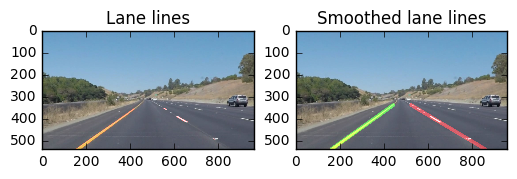

SOLIDYELLOWLEFT.JPG


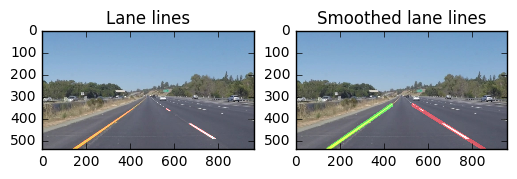

SOLIDWHITECURVE.JPG


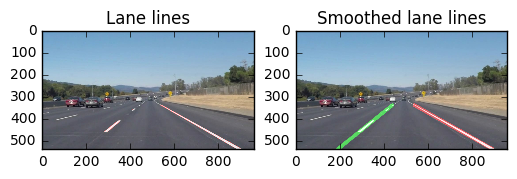

SOLIDWHITERIGHT.JPG


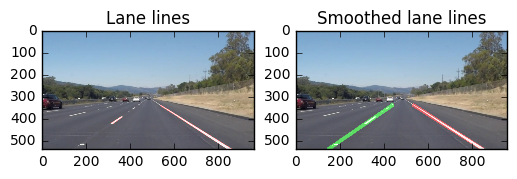

WHITECARLANESWITCH.JPG


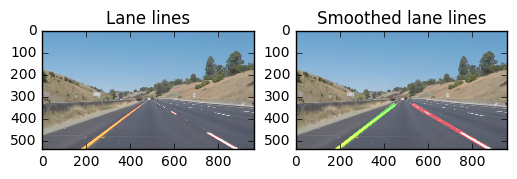

SOLIDYELLOWCURVE2.JPG


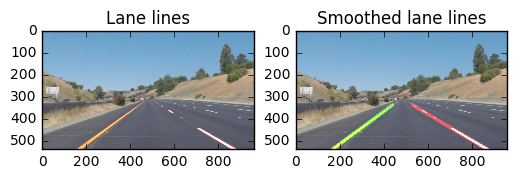

In [17]:
# Initialize the prev_lines list for storing the line information of the previous frame
prev_lines = []
# Since all images are independent we don't have to use the information from the previous frame
# Deactivate the filtering process
is_video_file = False
run_images()

## Process Videos
***
Function to run pipeline for the videos in the main folder: **solidWhiteRight.mp4** and **solidYellowLeft.mp4**

In [35]:
# Activate the filtering process - this will enable smoother transition from frame to frame
is_video_file = True

In [ ]:
white_output = 'Results/white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

In [ ]:
# Initialize the prev_line to empty list 
prev_lines = []
yellow_output = 'Results/yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

## Challenge Video
***
In this video the road color changes and there are shadows on the road. Both of these causes some distortions in the line finding algorithm. The method suggested by the tutorial http://docs.opencv.org/trunk/df/d9d/tutorial_py_colorspaces.html transforms the image to HSV color spectrum which makes it easier to select colors. 

**NOTE**: Since this video has different sizes **min_y** and **vertices** variables needs to be changed. Activate the commented out variables in the **process_image** function. Hood of the car needs to be masked by altering region of interest. 

In [ ]:
prev_lines = []
is_video_file = True
challenge_output = 'Results/extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image, apply_to=[])
challenge_clip.write_videofile(challenge_output, audio=False)

## Reflection
***

The implementation includes steps summarized below:

* White and yellow color selection using after BGR to HSV conversion 
* Gray scale conversion and gaussian smoothing to reduce noise 
    + Kernel size was assigned 5 and it seemed to work fine. 
* Edge detection using Canny algorithm 
    + Low threshold = 100 and high threshold = 200
    + These values can be further adjusted to reduce edges generated by the shadows in the challenge problem
* Hough transformation for finding the lines
    + threshold_hough = 20
    + min_line_length = 7
    + max_line_gap = 5
    + Threshold for sine wave intersection counts can be adjusted to reject small lines
    + Minimum line length can also be increased to find only large coherent lines 
    + Maximum line gap was assigned to be 5 pixels. This can be reduced to eliminate lines with larger gaps to be displayed as single line. 
    + Overall these parameters needs to be further adjusted for the challenge video. 
* Add lines on the images/frames

Line detection has been widely studied in the literature and Google Scholar search could lead to some new state-of-the-art techniques used by the research community. I would like to revisit this problem after I read and learn more about it. 